# 이미지 로드

이미지 데이터세트를 로드하고 사전처리하는 방법은 2가지가 있습니다.
+ keras.preprocessing.image_dataset_from_directory 사용해서 로드하기
+ tf.data를 사용하여 처음부터 자체 입력 파이프라인 작성



---
## 1. 설정

In [1]:
import numpy as np
import os
import PIL, PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

### 꽃 데이터 세트 다운로드하기

이 튜토리얼에서는 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
# 파일 다운로드
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# 압축을 풀어서 flower_photos라는 파일이름으로 저장하고 경로를 저장.
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
print(data_dir)
# 파일 경로
data_dir = pathlib.Path(data_dir)
print(data_dir)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos


[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)

다운로드한 후 (218MB), 이제 꽃 사진의 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다.

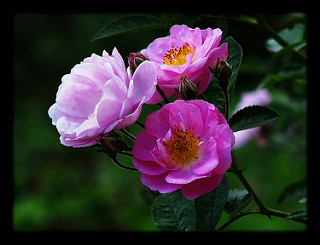

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## 2. keras.preprocessing을 사용하여 로드하기

[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)를 사용하여 이미지를 디스크에 로드해 보겠습니다.

### 데이터세트 만들기

로더를 위해 일부 매개변수를 정의합니다.

In [5]:
batch_size=32
img_height=180
img_width=180

In [6]:
# 데이터세트의 80%를 훈련 데이터세트로 만든다.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기

훈련 데이터세트의 처음 9개의 이미지는 다음과 같습니다.

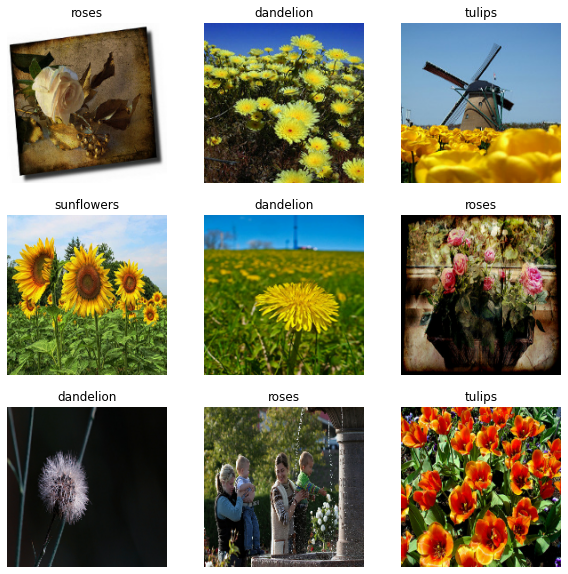

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
# 훈련 데이터세트는 1배치가 32개의 이미지로 이루어지도록 했다.
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break  # 훈련 데이터세트의 첫 번째 배치의 형상 출력

(32, 180, 180, 3)
(32,)


`image_batch`는 형상 `(32, 180, 180, 3)`의 텐서입니다. 형상 `180x180x3`의 32개의 이미지 배치입니다.(마지막 치수는 색상 채널 RGB를 나타냅니다). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

### 데이터 표준화하기

RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 

일반적으로 입력값을 작게 만들어야 합니다.

Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

In [11]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


참고 : 픽셀 값을 `[-1, 1]`로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성하면 됩니다.



### 성능을 위한 데이터세트 구성하기

`.cache()`는 첫 번째 에포크동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 데이터를 RAM과 같이 빨리 사용할수 있는 구간에 저장해두고, 다음에 사용할 때 빠르게 사용하기 위한 방식입니다. 이미지 데이터를 로딩한 이후, 한번 사용했다고 메모리에서 지우고 다시 불러오기를 반복한다면 성능저하가 심할테니까요.

`.prefetch()`는 데이터 로딩과 학습을 오버랩합니다. 모델이 s 스텝 훈련을 실행하는 동안 입력 파이프라인은 s+1 스텝의 데이터를 로딩합니다. 이렇게 하면 훈련을 하는 최대 스텝 시간과 데이터를 추출하는데 걸리는 시간을 단축시킬 수 있습니다.


In [13]:
# 원활하게 작동 가능한 적합한 CPU 또는 GPU 코어 수
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여드리겠습니다.

In [14]:
num_classes = 5

model = tf.keras.Sequential([
                             layers.experimental.preprocessing.Rescaling(1./255),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPool2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='Adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.fit(train_ds,
          batch_size=batch_size,
          validation_data=val_ds,
          epochs=3)

Epoch 1/3
92/92 [==============================] - 38s 92ms/step - loss: 1.3558 - accuracy: 0.4240 - val_loss: 1.1132 - val_accuracy: 0.5286
Epoch 2/3
92/92 [==============================] - 4s 44ms/step - loss: 1.0555 - accuracy: 0.5753 - val_loss: 1.0118 - val_accuracy: 0.6076
Epoch 3/3
92/92 [==============================] - 4s 44ms/step - loss: 0.9348 - accuracy: 0.6291 - val_loss: 0.9614 - val_accuracy: 0.5981


참고 : `model.fit` 말고 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다.

## 3. 세밀한 제어를 위해 tf.data 사용하기

keras.preprocessing 유틸리티는 이미지의 디렉토리(image_dataset_from_directory)에서 `tf.data.Dataset`을 작성하는 편리한 방법입니다.

이번에는 보다 세밀한 제어를 위해 `tf.data`을 사용하여 자체 입력 파이프라인을 작성해봅시다. 이전에 다운로드한 zip 파일 경로부터 시작합니다.

In [17]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
print(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
print(list_ds)

<TensorSliceDataset shapes: (), types: tf.string>
<ShuffleDataset shapes: (), types: tf.string>


In [18]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/12585131704_0f64b17059_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/5339004958_a0a6f385fd_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/5140791232_52f2c5b41d_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/3292654244_4a220ab96f_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/517054463_036db655a1_m.jpg'


In [19]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 훈련 및 검증으로 분할합니다.

In [20]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [21]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [22]:
def get_label(file_path):
    # 파일 경로를 경로 요소들의 리스트로 변환합니다.
    parts = tf.strings.split(file_path, os.path.sep)
    # 맨 뒤에서 2번째 요소가 클래스 디렉토리입니다.
    # 원핫인코딩으로 클래스 디렉토리와 같다면 1, 다르다면 0으로 인코딩합니다.
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)  # 배열에서 가장 큰 값의 인덱스를 반환합니다.

[tf.argmax](https://webnautes.tistory.com/1234)와 관련한 내용

In [23]:
def decode_img(img):
    # JPEG로 인코딩된 이미지(문자열)를 3차원(RGB) uint8 텐서(0~255)로 변환합니다.
    img = tf.image.decode_jpeg(img, channels=3)
    # 크기를 조정합니다.
    return tf.image.resize(img, [img_height, img_width])

In [24]:
def process_path(file_path):
    label = get_label(file_path)
    # 파일이 포함하고 있는 날 것의 데이터를 문자열로 로드합니다.
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

`Dataset.map`을 사용하여 `image, label` 쌍의 데이터세트를 작성합니다.

In [25]:
# num_parallel_calls를 사용해 여러 이미지들이 동시에 로드되고 처리되도록 한다.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for image, label in train_ds.take(1):
    print("image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

image shape:  (180, 180, 3)
Label:  0


### 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

+ 캐시 처리한다.
+ 잘 섞는다.
+ 배치 처리한다.
+ 데이터의 로드와 학습이 효율적으로 이루어져야한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 

In [27]:
def configure_for_performance(ds):
    ds = ds.cache()  # 캐리 처리
    ds = ds.shuffle(buffer_size=1000)  # 섞는다.
    ds = ds.batch(batch_size)  # 배치 처리
    ds = ds.prefetch(buffer_size=AUTOTUNE)  # 데이터 로드와 학습이 같이 일어날 수 있도록
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 데이터 시각화하기

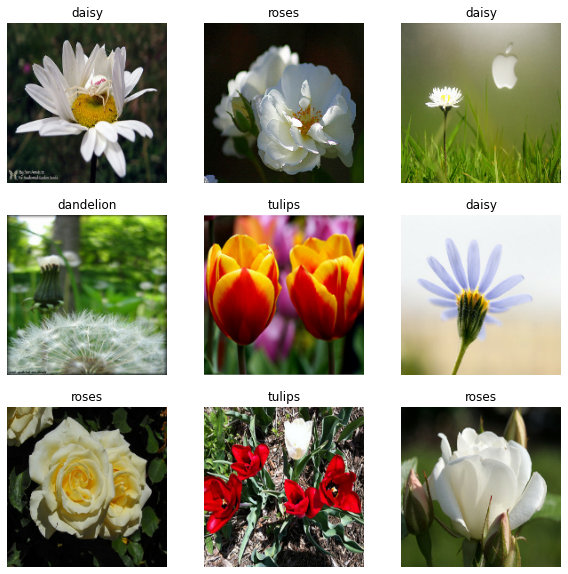

In [28]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

### 모델 계속 훈련하기

위의 `keras.preprocessing`에 의해 작성된 것과 유사한 `tf.data.Dataset`을 수동으로 빌드했습니다. 이전과 마찬가지로 실행시간을 짧게 유지하기 위해 작은 에포크동안 훈련합니다.

In [29]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 10s 91ms/step - loss: 0.8348 - accuracy: 0.6775 - val_loss: 0.8380 - val_accuracy: 0.6894
Epoch 2/3
92/92 [==============================] - 4s 48ms/step - loss: 0.6567 - accuracy: 0.7534 - val_loss: 0.8486 - val_accuracy: 0.6798
Epoch 3/3
92/92 [==============================] - 4s 48ms/step - loss: 0.5066 - accuracy: 0.8144 - val_loss: 0.8659 - val_accuracy: 0.6907


## 4. 텐서플로 데이터세트 사용하기

지금까지는 디스크에서 데이터를 로드하는 방법을 배워보았습니다. TensorFlow 데이터세트에서 다운로드하기 쉬운 대규모 데이터세트 카탈로그를 탐색하여 사용할 데이터세트를 찾을 수도 있습니다.

TensorFlow 데이터세트를 사용하여 꽃 데이터세트를 다운로드합니다.

In [30]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스가 있습니다.

In [31]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색합니다.

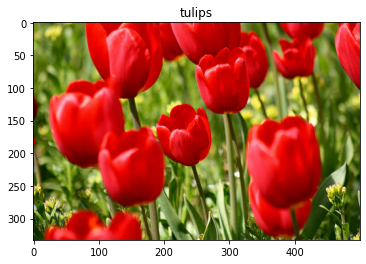

In [32]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

성능을 위해 각 데이터세트를 구성합니다.

In [33]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

[데이터 강화](https://www.tensorflow.org/tutorials/images/data_augmentation) 가이드를 방문하여 꽃 데이터세트 및 TensorFlow 데이터세트를 처리하는 전체 예제를 찾을 수 있습니다.